In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
# 1. Veri Yükleme ve Ön İşleme
# Örnek veri yükleniyor (Gerçek veri yolunu belirtin)
data = pd.read_csv("/content/sample_data/csv_building_structure.csv")  # Veri setini uygun dosya yolundan yükleyin

In [19]:
data = data.dropna(subset=['damage_grade'])

In [20]:
data['damage_grade'] = data['damage_grade'].str[-1].astype(int)

In [21]:
data['technical_solution_proposed'].unique()

array(['Major repair', 'Reconstruction', 'Minor repair', 'No need'],
      dtype=object)

In [22]:
pd.set_option("display.max_columns", None)
data

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Damaged-Used in risk,3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Damaged-Repaired and used,5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,2,Minor repair
3,120101000041,12,1207,120703,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,2,Minor repair
4,120101000051,12,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Repaired and used,1,Minor repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136102,212801000561,21,2107,210705,2,2,15,460,15,15,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Used in risk,2,Minor repair
136103,212801000571,21,2107,210705,2,2,9,392,16,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Used in risk,2,Minor repair
136104,212801000581,21,2107,210705,2,2,20,410,16,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Not used,3,Major repair
136105,212801000591,21,2107,210705,2,2,32,480,16,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Damaged-Used in risk,3,Major repair


In [25]:
# Özellikler ve hedef değişken
numerical_features = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
categorical_features = ['land_surface_condition', 'foundation_type', 'ground_floor_type',
                        'roof_type', 'plan_configuration', 'position']

features = numerical_features + categorical_features

target_damage = 'damage_grade'  # Hasar derecesi hedef değişkeni
target_repair = 'technical_solution_proposed'  # Onarım stratejisi hedef değişkeni

In [26]:

target_damage = 'damage_grade'  # Hasar derecesi hedef değişkeni
target_repair = 'technical_solution_proposed'  # Onarım stratejisi hedef değişkeni

X = data[features]
y = data[target_damage] - 1  # Target sınıfını 0 tabanlı hale getir

In [11]:
le = LabelEncoder()
data['technical_solution_proposed'] = le.fit_transform(data['technical_solution_proposed'])

print(le.classes_)

['Major repair' 'Minor repair' 'No need' 'Reconstruction']


In [27]:
for column in categorical_features:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

<ipython-input-27-2136037320da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-27-2136037320da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-27-2136037320da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [28]:
# SMOTE ile dengesizlik giderme
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [29]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Model doğruluklarını saklamak için bir sözlük
dict_accuracies = {}

In [30]:
# Modelleri eğit ve doğruluk hesapla
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    dict_accuracies[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.3f}")

Decision Tree Accuracy: 0.383
Random Forest Accuracy: 0.397
XGBoost Accuracy: 0.370
Logistic Regression Accuracy: 0.286


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


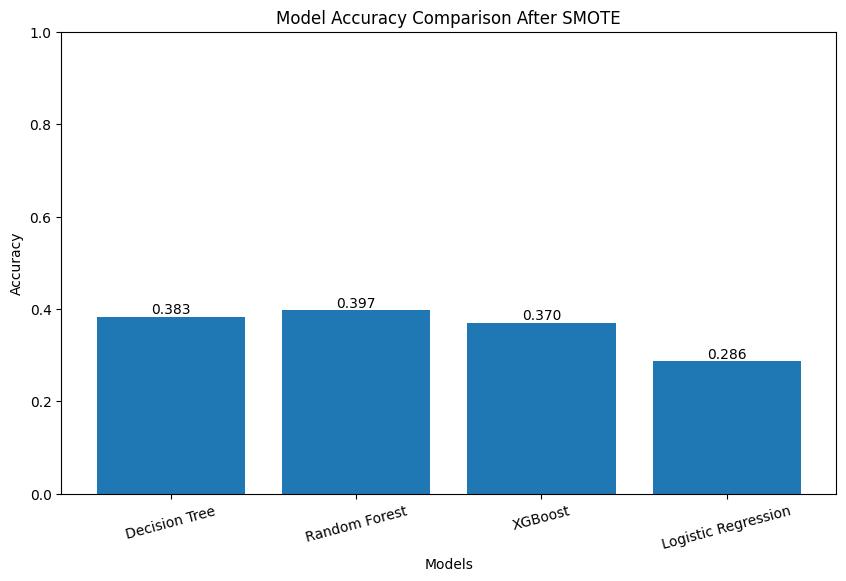

In [31]:
# Doğruluk oranlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(dict_accuracies.keys(), dict_accuracies.values(), color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison After SMOTE")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.bar_label(plt.bar(dict_accuracies.keys(), dict_accuracies.values()), fmt='%.3f')
plt.xticks(rotation=15)
plt.show()